https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/outlier_detection_hampel_filter.ipynb

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np 

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def random_walk_with_outliers(origin, n_steps, perc_outliers=0.0, outlier_mult=10, seed=42):
    '''
    Function for generating a random time series based on random walk.
    It adds a specified percentage of outliers by multiplying the random walk step by a scalar.
    
    Parameters
    ------------
    origin : int
        The starting point of the series
    n_steps : int
        Lenght of the series
    perc_outliers : float
        Percentage of outliers to introduce to the series [0.0-1.0]
    outlier_mult : float
        Scalar by which to multiply the RW increment to create an outlier
    seed : int
        Random seed

    Returns
    -----------
    rw : np.ndarray
        The generated random walk series with outliers
    indices : np.ndarray
        The indices of the introduced outliers 
    '''
    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)
    
    #set seed for reproducibility
    np.random.seed(seed)
    
    # possible steps
    steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)
    
    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult
    
    return rw, indices
 

In [4]:
rw, outlier_ind = random_walk_with_outliers(0, 1000, 0.01)

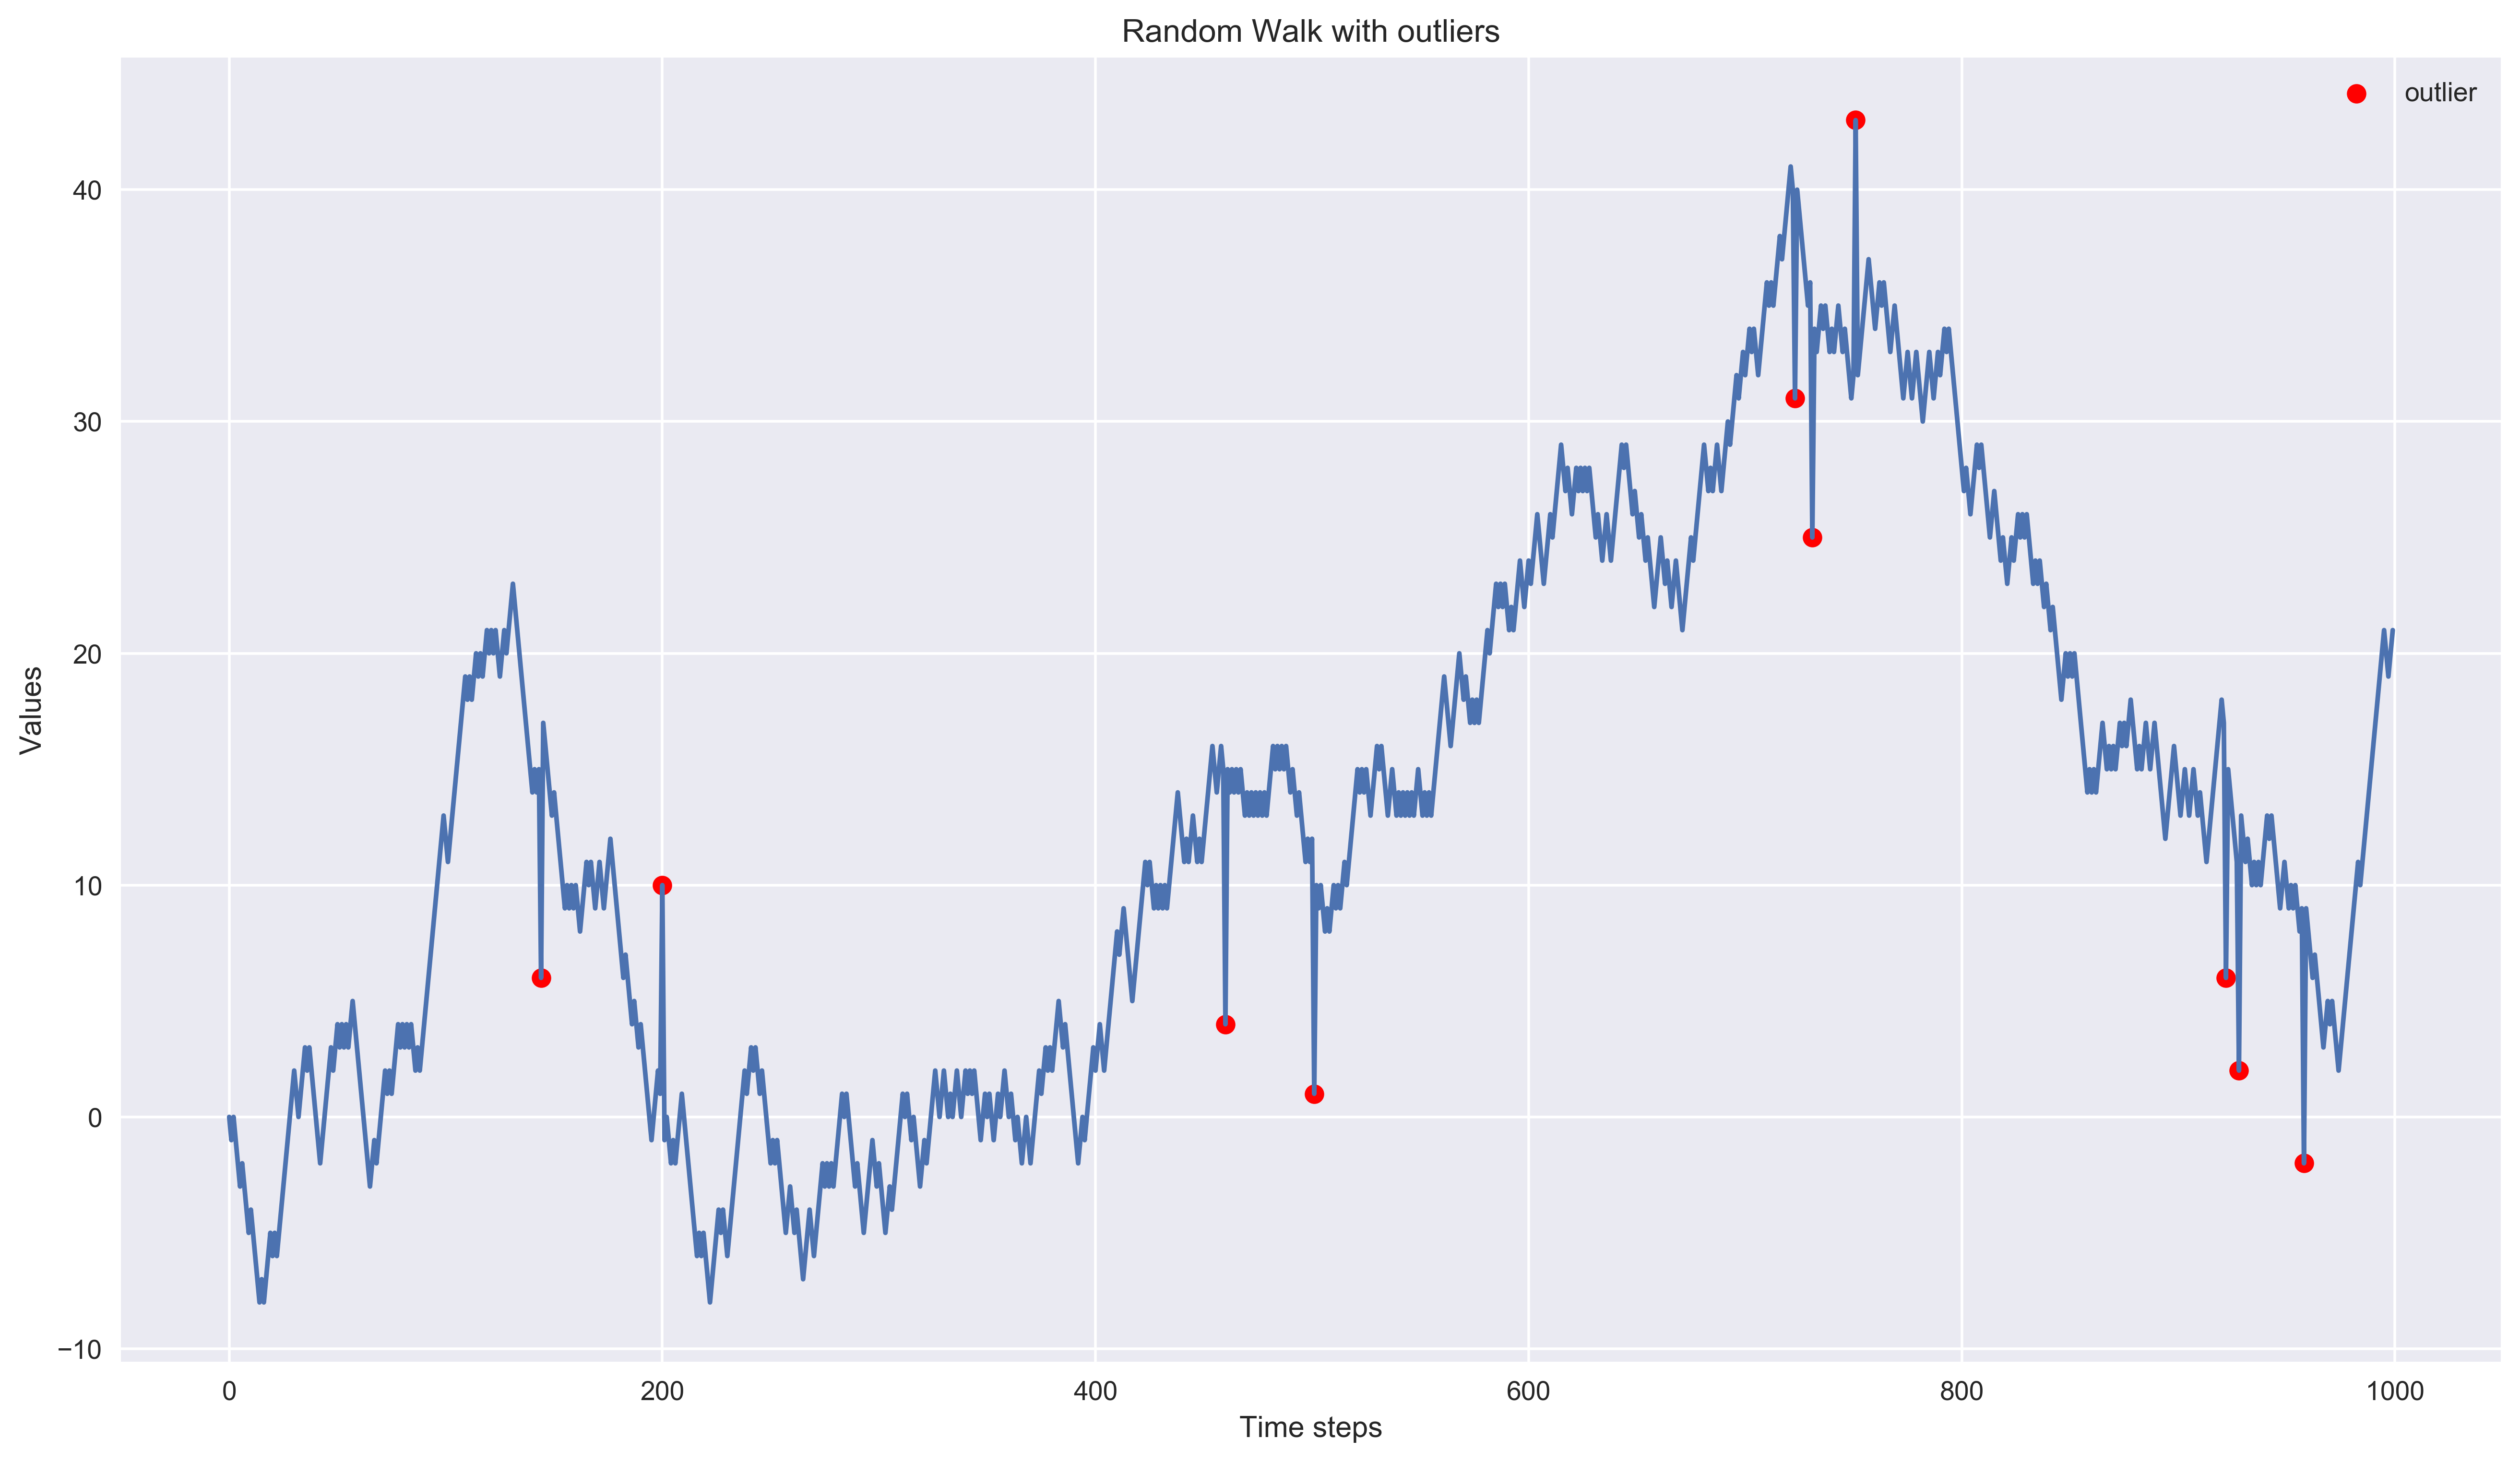

In [5]:
# Plot the path
plt.plot(np.arange(len(rw)), rw)
plt.scatter(outlier_ind, rw[outlier_ind], c='r', label='outlier')
plt.title('Random Walk with outliers')
plt.xlabel('Time steps')
plt.ylabel('Values')
plt.legend();

In [6]:
def evaluate_detection(series, true_indices, detected_indices):
    '''
    Function for evaluating the results of the outlier detection algorithm.
    Compares the series and presents the correctly identified outliers, the false 
    positives (non-outlier observations considered outliers) and the false negatives
    (missed outliers).
    
    Parameters
    ------------
    series : np.ndarray
        The series on which outlier detection was performed
    true_indices : np.ndarray
        The array containing outlier indices (ground truth)
    detected_indices : np.ndarray
        The array containing the indices of detected outliers

    Returns
    -----------
    tp : np.ndarray
        The array containing the indices of correctly detected outliers
    fp : np.ndarray
        The array containing the indices of incorrectly detected outliers 
    fn : np.ndarray
        The array containing the indices of missed outliers
    '''
    # calculate metrics
    tp = list(set(detected_outliers).intersection(set(true_indices)))
    fp = list(set(detected_outliers).difference(set(true_indices)))
    fn = list(set(true_indices).difference(set(detected_outliers)))
    perc_detected = 100 * len(tp) / len(true_indices)
    
    # create the plot
    fix, ax = plt.subplots(2, 1)
    
    ax[0].plot(np.arange(len(series)), series);
    ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier')
    ax[0].set_title('Original series')
    ax[0].legend()
    
    ax[1].plot(np.arange(len(series)), series);
    ax[1].scatter(tp, series[tp], c='g', label='true positive')
    ax[1].scatter(fp, series[fp], c='r', label='false positive')
    ax[1].scatter(fn, series[fn], c='k', label='false negative')
    ax[1].set_title('Algorithm results')
    ax[1].legend()
    
    # print out summary
    print('-' * 25 + ' Summary ' + '-' * 25)
    print(f'Outliers in the series: {len(true_indices)}')
    print(f'Identified outliers: {len(detected_indices)}')
    print(f'Correctly detected outliers: {len(tp)} ({perc_detected:.2f}% of all outliers).')
    print('-' * 59)
    
    return tp, fp, fn

In [7]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    '''
    Function for outlier detection using the Hampel filter.
    Based on `pracma` implementation in R.
    
    Parameters
    ------------
    input_series : np.ndarray
        The series on which outlier detection will be performed
    window_size : int
        The size of the window (one-side). Total window size is 2*window_size+1
    n_sigmas : int
        The number of standard deviations used for identifying outliers

    Returns
    -----------
    new_series : np.ndarray
        The array in which outliers were replaced with respective window medians
    indices : np.ndarray
        The array containing the indices of detected outliers
    '''
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [8]:
res, detected_outliers = hampel_filter_forloop(rw, 10)

------------------------- Summary -------------------------
Outliers in the series: 10
Identified outliers: 9
Correctly detected outliers: 8 (80.00% of all outliers).
-----------------------------------------------------------


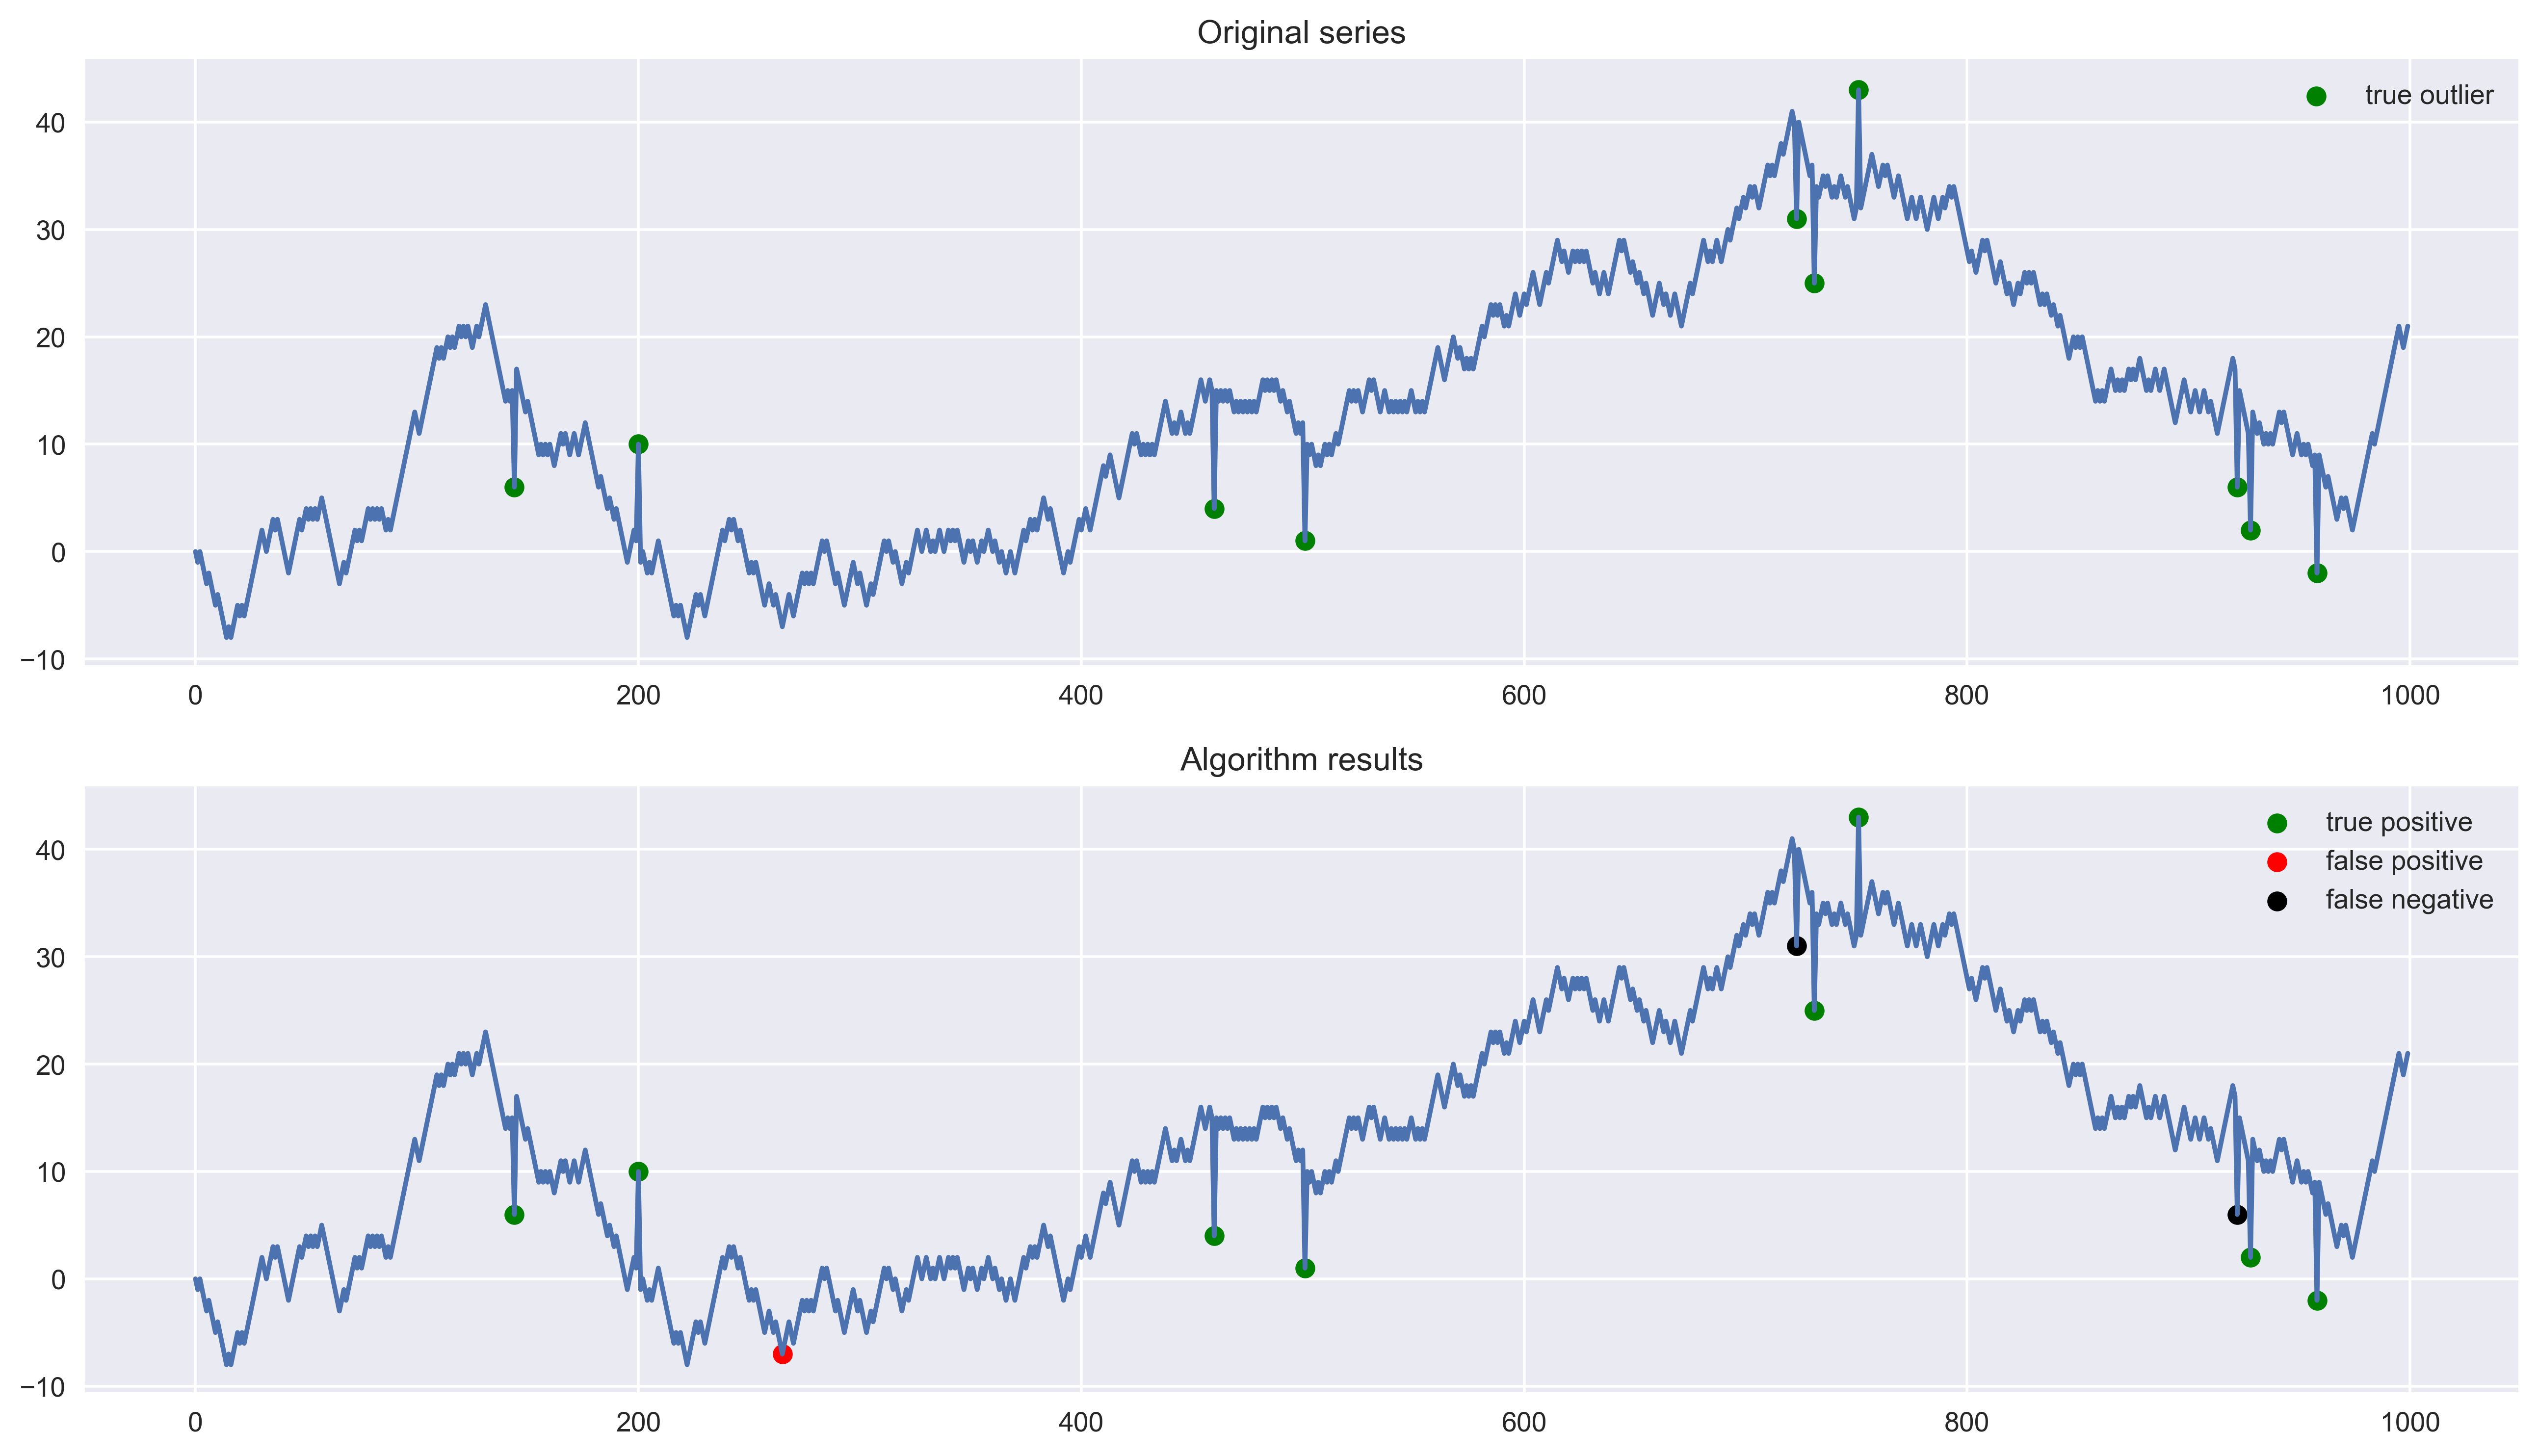

In [9]:
tp, fp, fn = evaluate_detection(rw, outlier_ind, detected_outliers)

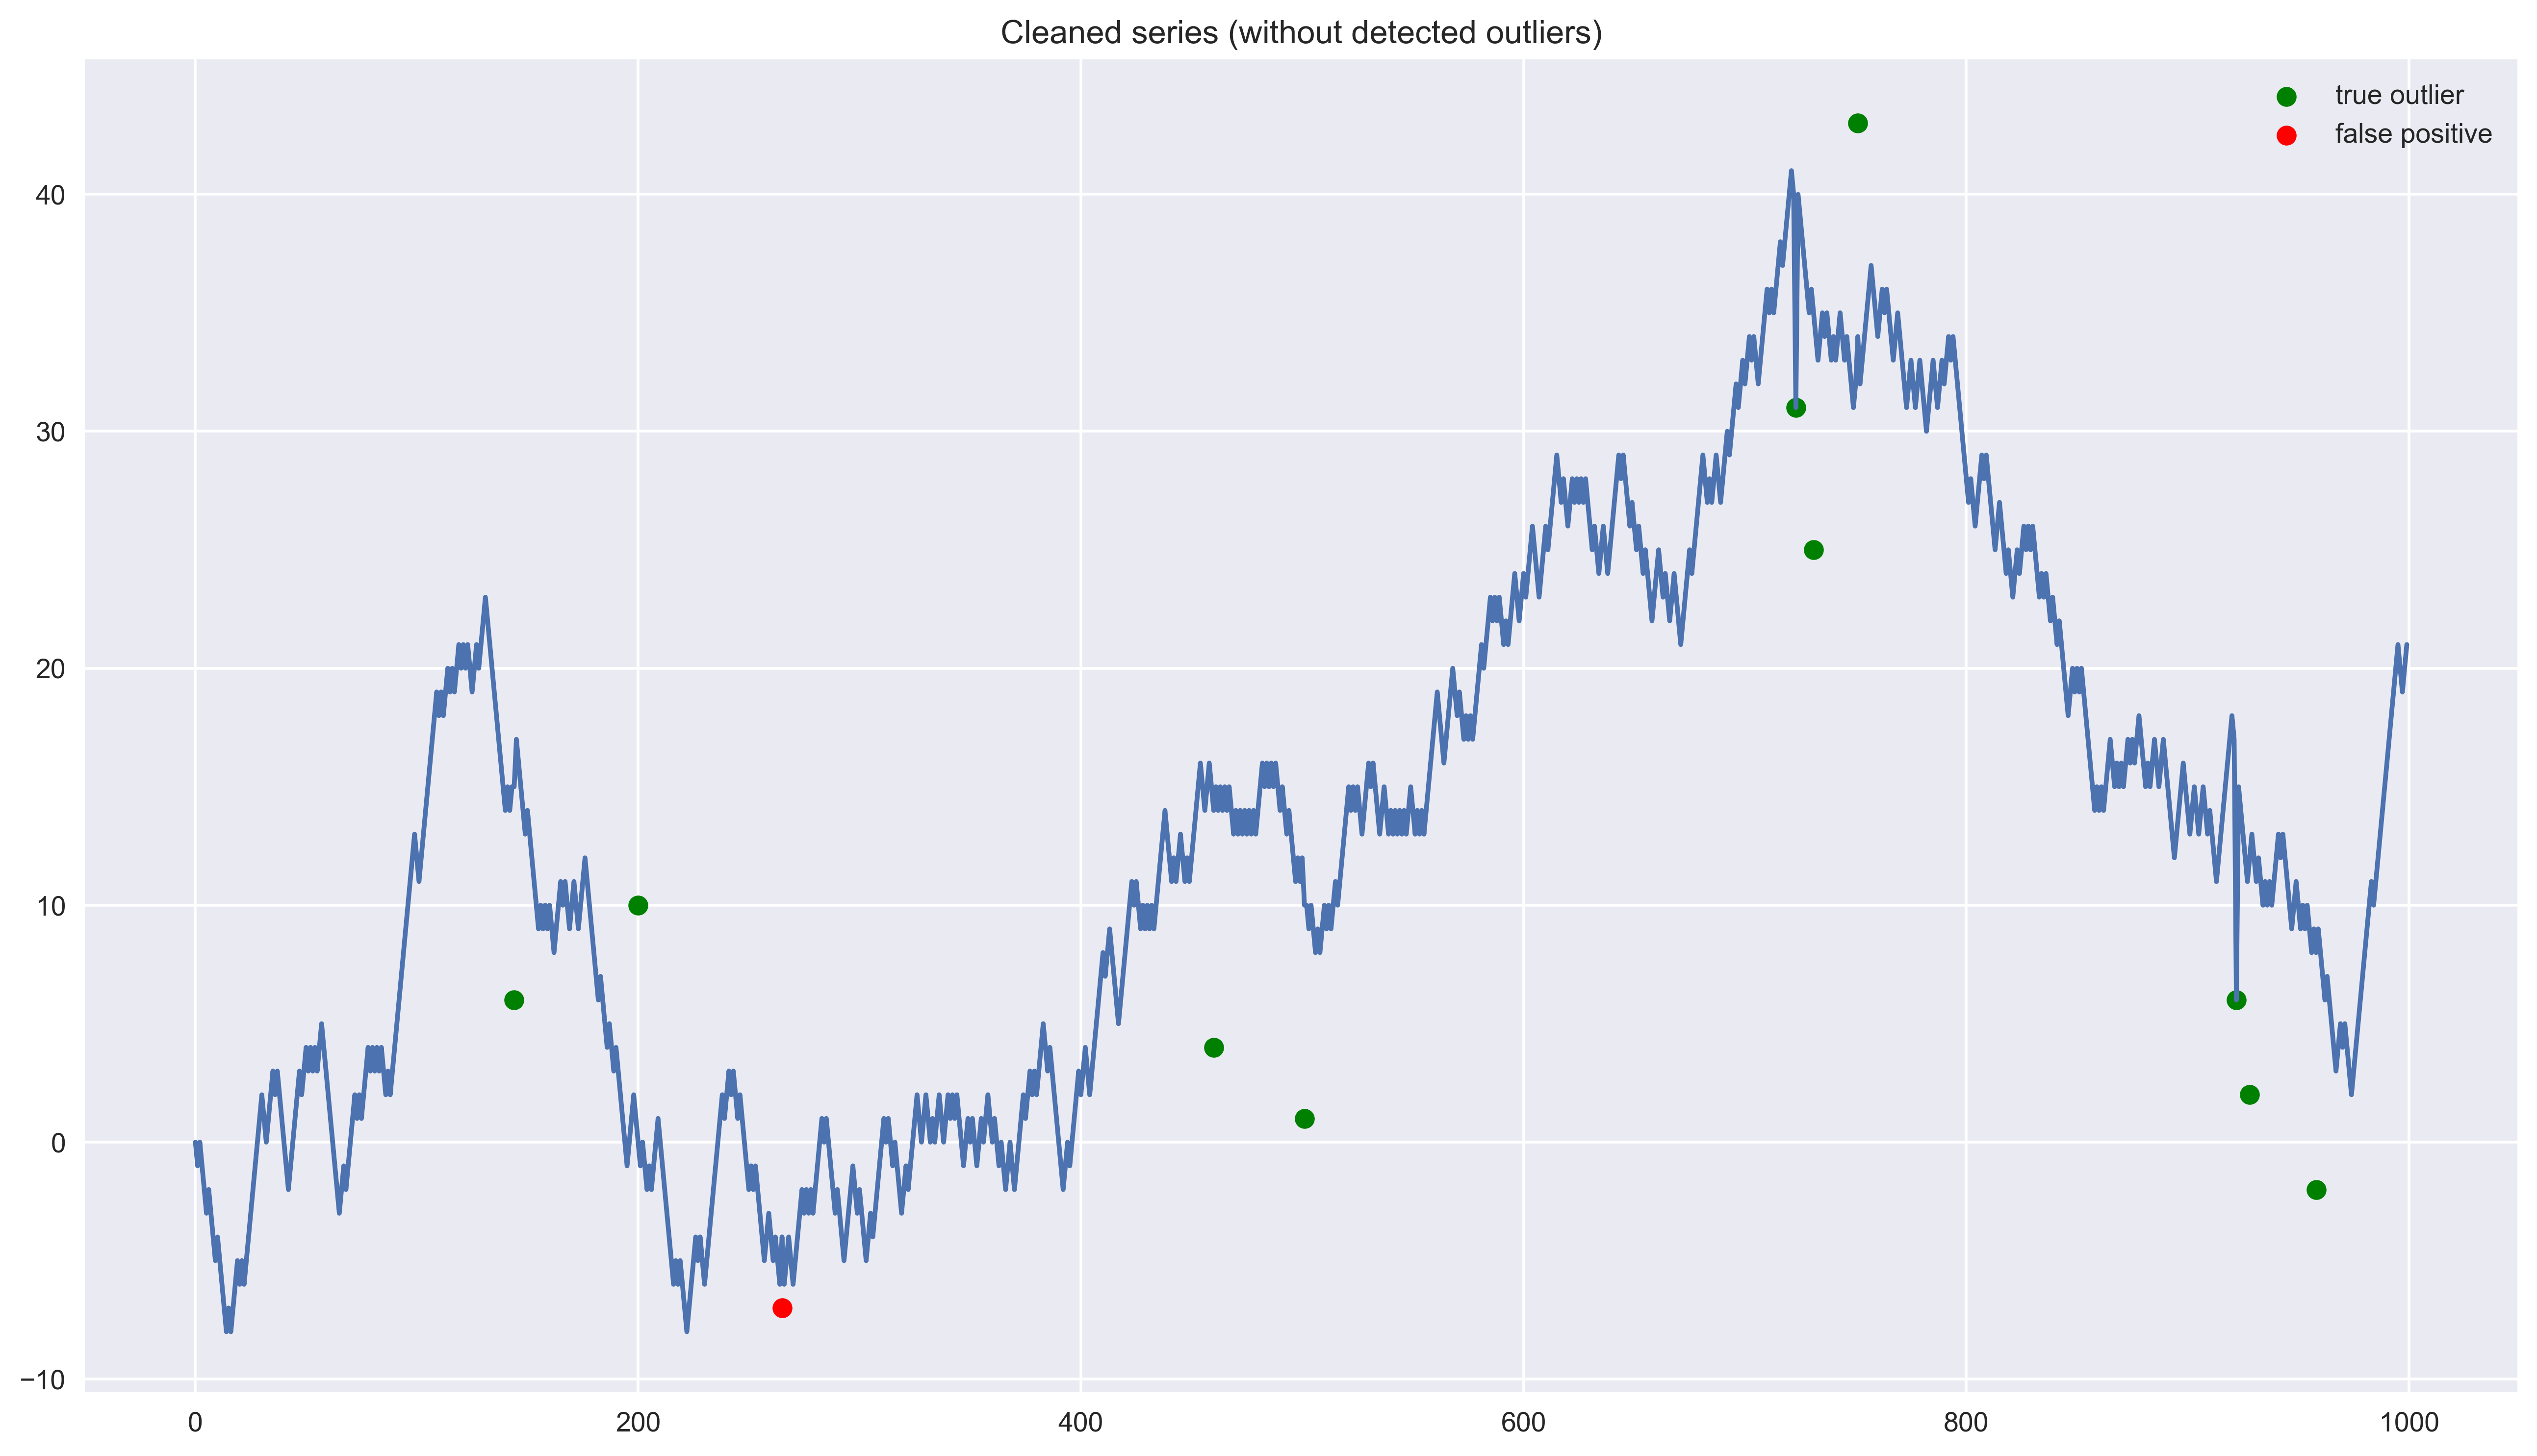

In [10]:
plt.plot(np.arange(len(res)), res);
plt.scatter(outlier_ind, rw[outlier_ind], c='g', label='true outlier')
plt.scatter(fp, rw[fp], c='r', label='false positive')
plt.title('Cleaned series (without detected outliers)')
plt.legend();

In [11]:
def hampel_filter_pandas(input_series, window_size, n_sigmas=3):
    '''
    Function for outlier detection using the Hampel filter.
    
    Parameters
    ------------
    input_series : pd.Series
        The series on which outlier detection will be performed
    window_size : int
        The size of the window (one-side). Total window size is 2*window_size+1
    n_sigmas : int
        The number of standard deviations used for identifying outliers

    Returns
    -----------
    new_series : pd.Series
        The array in which outliers were replaced with respective window medians
    indices : np.ndarray
        The array containing the indices of detected outliers
    '''

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    rolling_median = input_series.rolling(window=2*window_size, center=True).median()
    rolling_mad = k * input_series.rolling(window=2*window_size, center=True).apply(MAD)
    diff = np.abs(input_series - rolling_median)

    indices = list(np.argwhere(diff > (n_sigmas * rolling_mad)).flatten())
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

In [12]:
rw_series = pd.Series(rw)

In [13]:
res, detected_outliers = hampel_filter_pandas(rw_series, 10)

------------------------- Summary -------------------------
Outliers in the series: 10
Identified outliers: 9
Correctly detected outliers: 8 (80.00% of all outliers).
-----------------------------------------------------------


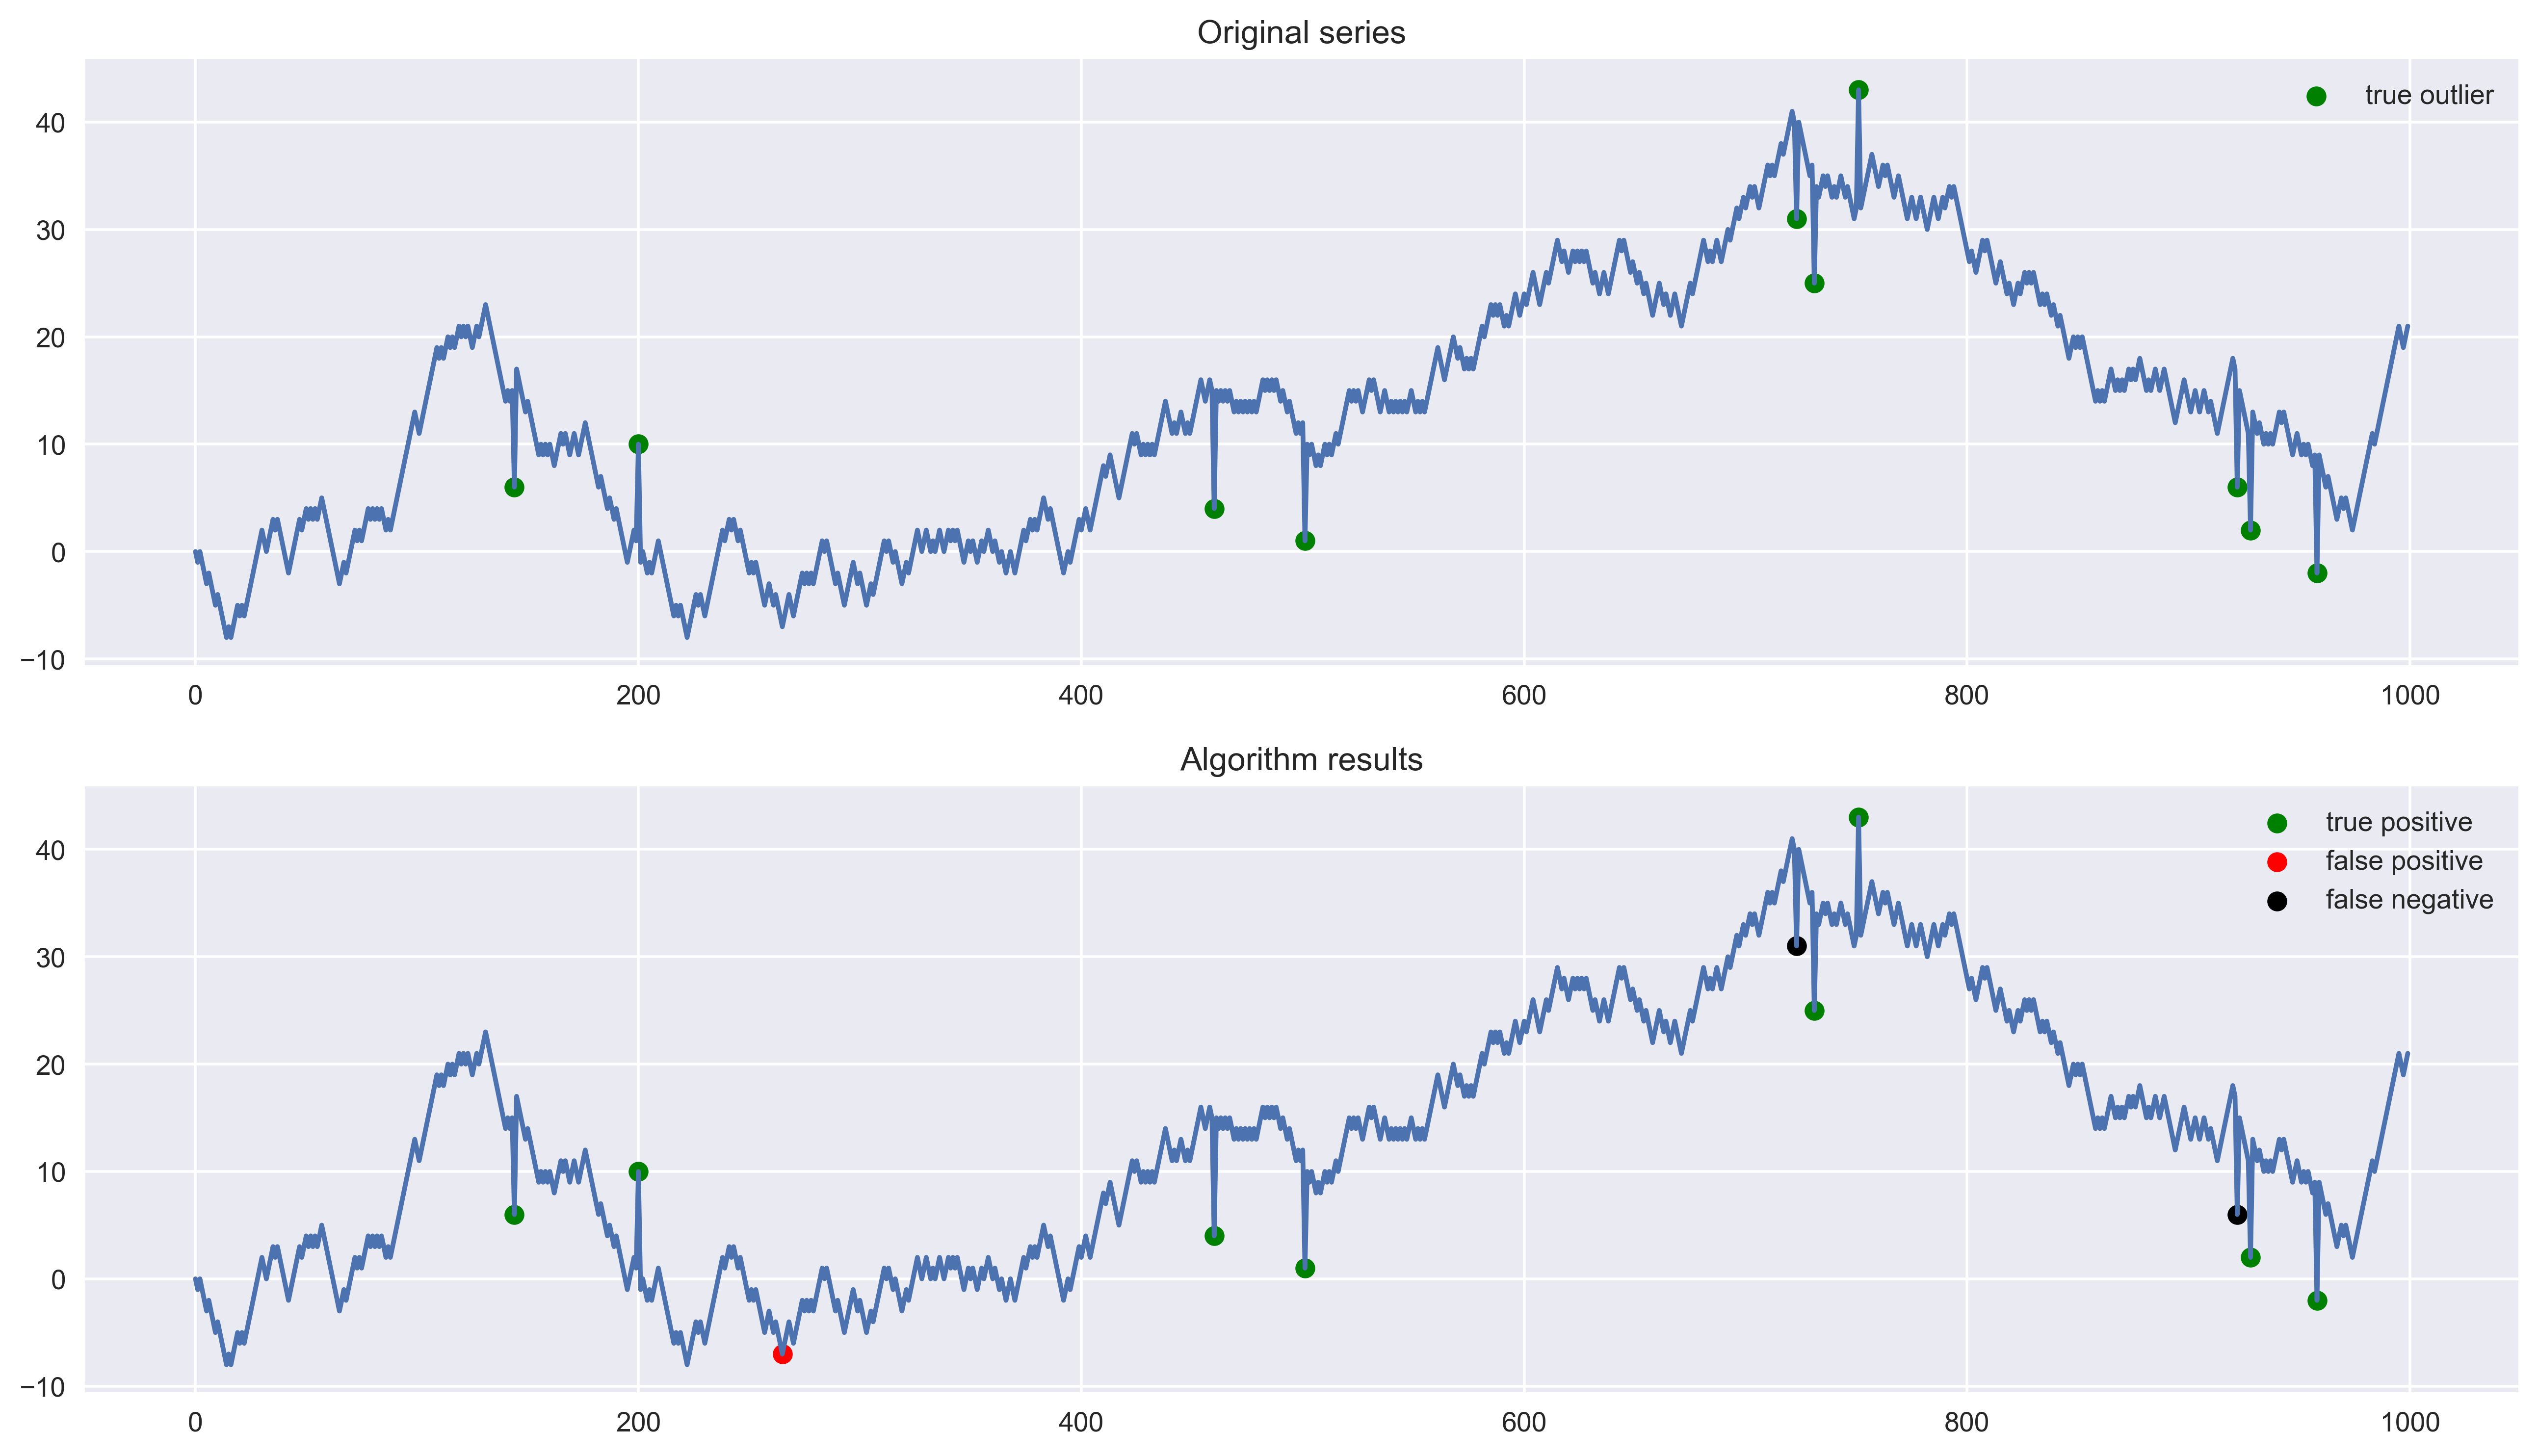

In [14]:
tp, fp, fn = evaluate_detection(rw, outlier_ind, detected_outliers)

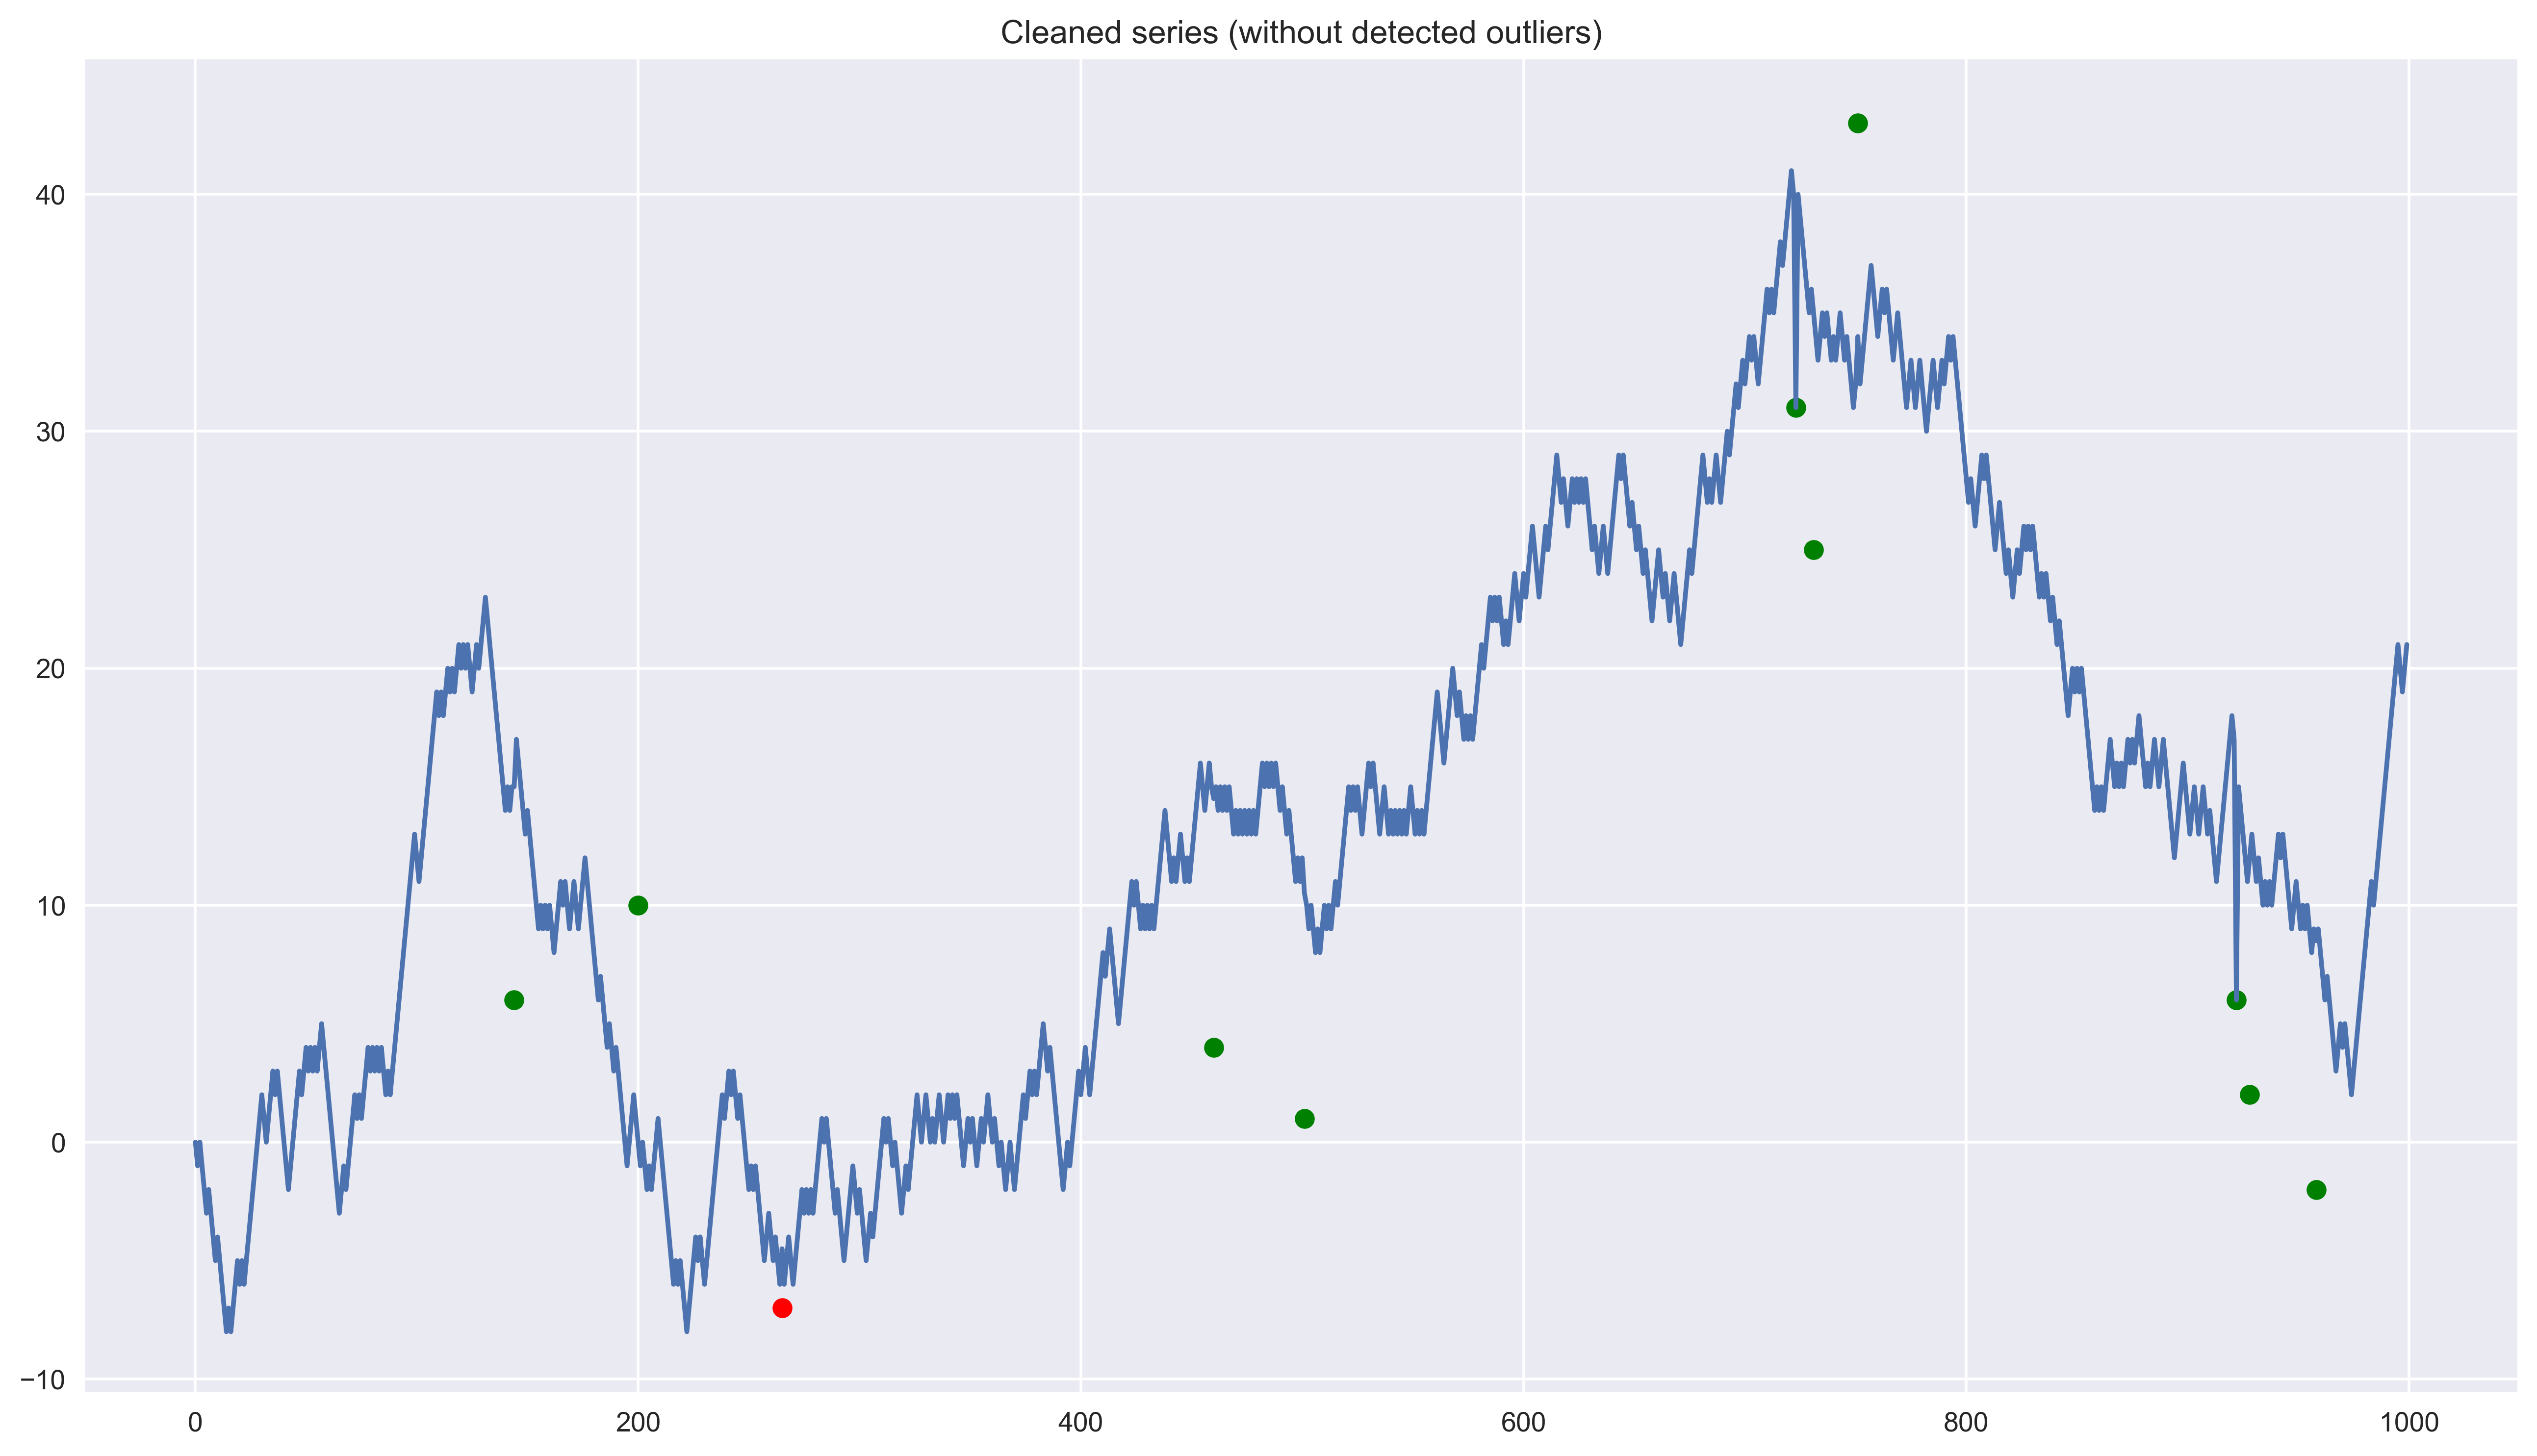

In [15]:
plt.plot(np.arange(len(res)), res);
plt.scatter(outlier_ind, rw[outlier_ind], c='g', label='true outlier')
plt.scatter(fp, rw[fp], c='r', label='false positives')
plt.title('Cleaned series (without detected outliers)');

In [16]:
%%timeit
res, detected_outliers = hampel_filter_forloop(rw, 10)

52.4 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
res, detected_outliers = hampel_filter_pandas(rw_series, 10)

52.7 ms ± 903 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
rw, outlier_ind = random_walk_with_outliers(0, 10 ** 5, 0.01)
rw_series = pd.Series(rw)

In [19]:
%%timeit
res, detected_outliers = hampel_filter_forloop(rw, 10)

5.32 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
res, detected_outliers = hampel_filter_pandas(rw_series, 10)

5.1 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
